# Extending The SEIR Model: A Monte Carlo Study

## Model Definition

The SEIR model is a standard mathematical model from epidemiology for modeling the outbreak of an infectious disease in a given population. The basic model consists of four states - suceptible (S), exposed (E), infectious (I), and removed (R). A susceptible individual becomes exposed to the virus through contact with infectious individuals, and so progresses from S to E. At disease onset the individual moves to state I, and upon recovery or death they move to R. Model parameters determine the rate of transfer between each state.

The SEIR model can be extended by including additional states and parameters which help to more fully capture the complexity of a particular outbreak. One example of this kind of extended SEIR model is presented in [Kissler et al. 2020](https://www.medrxiv.org/content/10.1101/2020.03.22.20041079v1.full.pdf). Their model stratifies cases by severity - that is, after exposure an individual either becomes a mild/asymptomatic, severe, or critical case. Mild/asymptomatic cases require no hospitalization, severe cases require hospitalization but no critical care, and critical cases require hospitalization including critical care. Mild/asymptomatic cases move straight from the infectious state to the removed state. Severe cases move from the infectious state to the non-critical hospitalization state, then to removed. Critical cases move from the infectious state to hospitalization, to ICU, to removed.

The states, paths, and parameters for the Kissler model are depicted here (diagram and table directly from the paper):

<img src="./images/diagram.png" width="600">
<img src="./images/parameters.png", width="600">

## Notebook Objectives

In this notebook we do the following:
1. Implement the model from the Kissler paper
2. Extend the model by treating parameters as random variables
3. Use monte carlo methods with the stochastic model to generate a more robust forecast

First we import the necessary libraries.

In [442]:
# imports
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy.random as R

## 1. Implementing the Kissler model

Here we implement the model as a python class with attributes for storing initial conditions, parameter values, statistics of interest, and the simulated outbreak as a time-series. We define intuitive methods for interfacing with the model - `KisslerModel.run()` and `KisslerModel.summarize()`. After instantiating a model with a set of initial conditions, simply run these commands to generate and visualize a simulation.

In [466]:
class KisslerModel:
    """
    this class implements the Kissler model;
    see: https://www.medrxiv.org/content/10.1101/2020.03.22.20041079v1.full.pdf
    
    follows the 'model' interface:
    
        kissler = KisslerModel(initVals)
        stats = kissler.run()
        kissler.visualize()
    
    using the model interface facilitates MCMC methods:
    
        trials = []
        for i in range(1000):
            model = drawModel(initialConditions)
            stats = model.run()
            trials.append(stats)
            
        results = mean(trials)
        return results
        
    """
    
    # list all states of the model
    states = [
        "S",
        "E",
        "Ir", "Rr",
        "Ih", "Hh", "Rh",
        "Ic", "Hc", "Cc", "Rc"
    ]
    
    def __init__(self, initVals=None, nSteps=150):
        
        # store provided number of timesteps to simulate - default is 100 days
        self.nSteps = nSteps
        
        # store provided initial values for each state
        # Q. Should it be optional to specify initial values?
        # ---> could just define a sensible default initial state
        self.initVals = initVals
        
        # store param values after draw
        self.params = KisslerParameters()
        
        # store per-state time-series generated by model run 
        self.simulation = {}
        
        # store statistics computed from simulation data
        self.stats = {}
        
    def monteCarlo(self, n):
        simulations = []
        statistics = []
        for i in range(n):
            model = KisslerModel(self.initVals)
            model.run(stochastic=True)
            simulations.append(model.simulation)
            statistics.append(model.stats)

        # average the statistics
        self.stats = pd.concat(statistics, axis=1).mean(axis=1)
        
        # average the time-series
        self.simulation = pd.concat(simulations, keys=[i for i in range(n)]).mean(level=1)

    def run(self, stochastic=False):
        """
        1. assign values to parameters
        2. run the simulation
        3. compute statistics
        """
        
        if stochastic:
            self.params.draw()
        else:
            self.setParams()
            
        self.runSimulation()
        self.computeStats()
    
    def setParams(self):
        """set param values to fixed (i.e., non-random) values from the paper"""
        self.params.vals = {
            "maxR0": 2, "seasonal": .7, "phi": -26.6,  # beta is a cosine fn defined by these params
            "v": .217,                                 # inverse of mean incubation period
            "pr": .956, "ph": .0308, "pc": .0132,      # rel freq of cases mild/asymptomatic, hospitalized, critical care
            "gamma": .2,                               # inverse of mean infectious period
            "deltah": .125, "deltac": .167,            # inverse of mean non-icu hospital stay for hospitalized, critical care
            "xic": .1                                  # inverse of mean critical care duration
        }
        
    def computeStats(self):
        """
        compute statistics of interest from simulation results
            - size of peak
            - time of peak
            - how much of the population gets sick by the end of the outbreak
            - duration of outbreak
            - herd immunity threshold (1 - 1/R0)
                -> see: https://watermark.silverchair.com/cir007.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAlIwggJOBgkqhkiG9w0BBwagggI_MIICOwIBADCCAjQGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMk9OCqPVIv3T5YtV2AgEQgIICBXyGo2h1igPCTwJOPBYsQFpvzpqcCY42-bR1uT59WdeNExXKanT2b0sD_Yrj6V5M9jnSb9mHk-BjGkP7OuiHoU42GGR5z6zoBsDFG6YF0wmhtDRBkQB3f5wInaXlbU_IalYnOqgFEz4NQU3gpZDFysq-AUWicEZFJMiuguEP_iTSpaw6tDHfoxnZiFoeIqQRbg6uGGGh8nKHA4UaSMZ0dqvooNtCzokaJFKL4ceLvu_TZdpqS2mgIH5rc38bLhoZHMQ5uBAN8t_4hlGfnu_o9U1-yZcgicbcQsAp7bTqjoaDvGKTcqTj29YeM-FaP3Zpdr58LmxwUyV2S6R0_KJhH9bwMqNvXNAdqpf4lYsSonzE0IA1QumGASokucYdFSWGPp4Fzzfzn9GU3Wxx-OzdFS8lNCHCgWJkC8Iumnumkhf7BFVp6RBoAxZru04hSB1TMWytuhkeX41bseiWkgux1EGRtclaLNGosCmYHKwOf7hAUvC0UYkSR8HlsUkdPvUzdjiYd1yAt1YYCcz0YNhrDz8HSapdXGb3q09TSeEEqKbv2pRi4GCIxqs_qTeSQHPZj0N28gVjW0AetUWh0p3uzCDRGHUn8nIGOmyUYp_-HV5dT8lhSnjIKJNejSUmtiQNS8iucu18wLbAqVo39eVhq4thObjN0_7hWQTDYMZx1dclGrPQgdQ
            - time at which herd immunity threshold reached
            - time at which 50% of the population is recovered/removed        
        """
        
        infectionStates = [
            "E",
            "Ir",
            "Ih", "Hh",
            "Ic", "Hc", "Cc"
        ]
        
        removedStates = [
            "Rr",
            "Rh",
            "Rc"
        ]
        
        '''
        stats = {
            "peak_size": 0, # max(E + Ir + Ih + Ic + Hh + Hc + Cc)
            "peak_time": 0, # timestep at which 'peak_size' occurs
            "long_run_removed": 0, # (Rr + Rh + Rc) at final timestep
            "outbreak_duration": 0, # timestep (at tail of outbreak) at which (E + Ir + Ih + Ic + Hh + Hc + Cc) < .01            
            "herd_immunity_threshold": 0, # 1 - 1/R0
            "herd_immunity_time": 0, # min(timestep at which (Rr + Rh + Rc) >= herd_immunity_threshold)            
            "half_removed_time": 0 # min(timestep at which (Rr + Rh + Rc) >= .5)
        }
        '''
        
        df = pd.DataFrame.from_dict(self.simulation)
        totalActiveCases = df[infectionStates].sum(axis=1)
        totalRemovedCases = df[removedStates].sum(axis=1)
        
        # peak stats
        peak_size = totalActiveCases.max()
        peak_time = totalActiveCases.idxmax()
        
        # here arbitrarily defining "end of outbreak" as
        # when fewer than 1% of the population are active cases
        outbreak_duration = totalActiveCases[peak_time:].lt(.01).idxmax() + peak_time
        
        # how much of the population will have been infected by the end of the outbreak
        long_run_removed = totalRemovedCases.array[-1]
        
        # first time at which 50% of the population have had the infection
        half_removed_time = totalRemovedCases.ge(.5).idxmax()
        
        # crude estimate - "ballpark"
        herd_immunity_threshold = 1 - 1/self.params.vals["maxR0"]
        herd_immunity_time = totalRemovedCases.ge(herd_immunity_threshold).idxmax()
        
        self.stats = pd.DataFrame.from_dict({
            "peak_size": [peak_size],
            "peak_time": [peak_time],
            "outbreak_duration": [outbreak_duration],
            "long_run_removed": [long_run_removed],
            "half_removed_time": [half_removed_time],
            "herd_immunity_threshold": [herd_immunity_threshold],
            "herd_immunity_time": [herd_immunity_time]
        }, orient='index', columns=[""])
        
    def initStates(self):
        """assign initial relative frequency to each state"""
        freq = {}
        for state in self.states:
            freq[state] = [self.initVals[state]]
        return freq
    
    def runSimulation(self):
        """
        given: 
            - initial conditions set
            - parameter values set
        
        run the simulation
        """
        
        # set initial conditions
        freq = self.initStates()

        # retrieve parameter values
        p = self.params.vals
        maxR0, seasonal, phi = p["maxR0"], p["seasonal"], p["phi"]
        v, pr, ph, pc = p["v"], p["pr"], p["ph"], p["pc"]
        gamma = p["gamma"]
        deltah, deltac = p["deltah"], p["deltac"]
        xic = p["xic"]

        # define beta (the cosine fn) using provided params: maxR0, seasonal, phi
        def betaFunc(j):
            return math.cos((2*math.pi*(j + phi))/364)*maxR0*(1-seasonal)/2 + maxR0*(1+seasonal)/2

        # define increment per state for a given time step
        # increment is the difference between the jth and (j+1)th step
        def increment(j):
            beta = betaFunc(j)
            return {
                "S": -beta*freq["S"][j]*(freq["Ir"][j] + freq["Ih"][j] + freq["Ic"][j]),
                "E": beta*freq["S"][j]*(freq["Ir"][j] + freq["Ih"][j] + freq["Ic"][j]) - v*freq["E"][j],
                "Ir": pr*v*freq["E"][j] - gamma*freq["Ir"][j],
                "Rr": gamma*freq["Ir"][j],
                "Ih": ph*v*freq["E"][j] - gamma*freq["Ih"][j],
                "Hh": gamma*freq["Ih"][j] - deltah*freq["Hh"][j],
                "Rh": deltah*freq["Hh"][j], 
                "Ic": pc*v*freq["E"][j] - gamma*freq["Ic"][j],
                "Hc": gamma*freq["Ic"][j] - deltac*freq["Hc"][j],
                "Cc": deltac*freq["Hc"][j] - xic*freq["Cc"][j],
                "Rc": xic*freq["Cc"][j]
            }

        # simulate the specified number of timesteps
        for t in range(self.nSteps):
            diffEq = increment(t)
            for state in self.states:
                val = freq[state][t] + diffEq[state]
                freq[state].append(val)
        
        
        self.simulation = pd.DataFrame(freq)
        
    def visualize(self):
        """visualize simulated data (and statistics)"""
        fig, ax = plt.subplots()
        fig.set_size_inches(16, 8)

        t = [i for i in range(self.nSteps+1)]
        for state in self.states:
            ax.plot(t, self.simulation[state], label=state)

        ax.set(
            xlabel="days", 
            ylabel="relative frequency", 
            title="relative frequency per state over time"
        )
        ax.legend()
        ax.grid()

        plt.show()
    
    def summarize(self):
        '''view simulation results'''
        # print('COVID-19 Progression:') # -> improve plot presentation, labels, etc.
        self.visualize()
        print('Statistics of Interest:\n')
        print(self.stats.to_string())
        

### Running the model

Here we define a set of initial conditions to provide to the model, then run the simulation. This initial run of the model uses the parameter values from the Kissler paper as shown in the table at the beginning of this notebook.

In [467]:
# population size
N = 1000000

# initial relative frequency for each state
initVals = {
    "S": 1 - 1/N,
    "E": 1/N,
    "Ir": 0, "Rr": 0,
    "Ih": 0, "Hh": 0, "Rh": 0,
    "Ic": 0, "Hc": 0, "Cc": 0, "Rc": 0
}

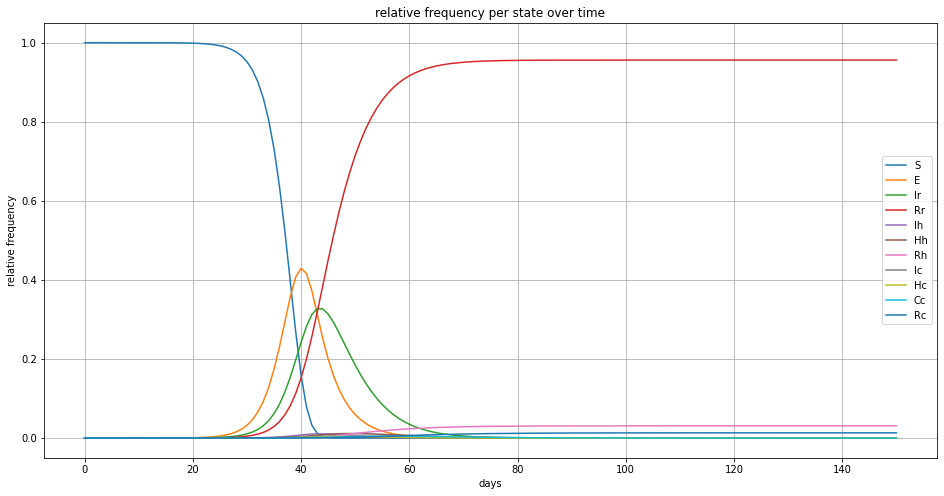

Statistics of Interest:

                                   
peak_size                  0.719186
peak_time                 41.000000
outbreak_duration        112.000000
long_run_removed           0.999998
half_removed_time         46.000000
herd_immunity_threshold    0.500000
herd_immunity_time        46.000000


In [468]:
# run the model and visualize results
model = KisslerModel(initVals)
stats = model.run()
model.summarize()

## 2. Making it a stochastic model

As we are in the early stages of the pandemic, it can be difficult to accurately estimate model parameters - for example, the incubation period, duration of infectiousness, or basic reproductive number. One way to account for this uncertainty is to treat model parameters as random variables, each following a distribution which is either fitted to data or otherwise defined to reflect the research community's current knowledge and expectations regarding that parameter.

Here we define the `KisslerParameters` class which serves as a stochastic extension to the Kissler model. Now when we run the model we can specify that we'd like to run the stochastic model, and each time we run it we draw from the parameter distributions. That is to say, each time we run the stochastic model we get a different result.

In [446]:
class KisslerParameters():
    '''handles sampling from parameter distributions'''
    
    def __init__(self):
        self.vals = {}
    
    def draw(self):
        """assign value to each model parameter by drawing from that parameter's distribution"""
        
        self.vals = {
            "phi": -26.6, # HERE - fixme - make draw, even if pointless for now
            
            "maxR0": self.drawR0(), 
            "seasonal": self.drawSeasonal(),   
            "v": 1/self.drawIncubation(),        
            "gamma": 1/self.drawInfectious(),                               
            "deltah": 1/self.drawLOSNoCritical(), 
            "deltac": 1/self.drawLOSPreCritical(),            
            "xic": 1/self.drawLOSCritical()                                  
        }
        
        self.vals["pr"], self.vals["ph"], self.vals["pc"] = self.drawStrataFreqs()
        
    def drawR0(self):
        '''the basic reproductive number'''
        return R.uniform(2,2.5)
        
    def drawSeasonal(self):
        '''size of effect of seasonal forcing'''
        return R.triangular(.7,.8,1)
    
    ## NOTE: the weibull distributions are shifted so as to
    ## begin at 1 rather than 0, since these rate parameters
    ## cannot have values smaller than the size of the model timestep
    ## this ensures that the signal between states is never amplified
    ## e.g., 5 people in exposed -> 7 people become infectious
    ## this is an impossible situation in reality,
    ## and it is avoided in the model by this shifting of these distributions
    
    def drawIncubation(self):
        '''exposure to onset'''
        return R.weibull(2.16)*4.1 + 1
        
    def drawInfectious(self):
        '''length of infectious period / onset to hospitalization'''
        return R.weibull(1.8)*3.37 + 1
    
    def drawLOSNoCritical(self):
        '''length of hospital stay with no visit to the ICU'''
        return R.weibull(3.88)*7.78 + 1
    
    def drawLOSPreCritical(self):
        '''length of hospital stay prior to transfer to ICU'''
        return R.weibull(1.31)*5.39 + 1
    
    def drawLOSCritical(self):
        '''duration of critical care'''
        return R.weibull(3.76)*9.98 + 1
    
    def drawStrataFreqs(self):
        '''relative frequency of each stratum - mild / severe / critical'''
        
        # draw percentages
        mild = R.triangular(75,80,85)
        severe = R.triangular(12,13.8,15)
        critical = R.triangular(3,4.7,6)

        # scale
        total = mild + severe + critical
        m, s, c = mild / total, severe / total, critical / total
        
        return m, s, c

### Run the stochastic model

Here we run the stochastic model three times and visualize the results of each run. We note that each simulation yields different results.

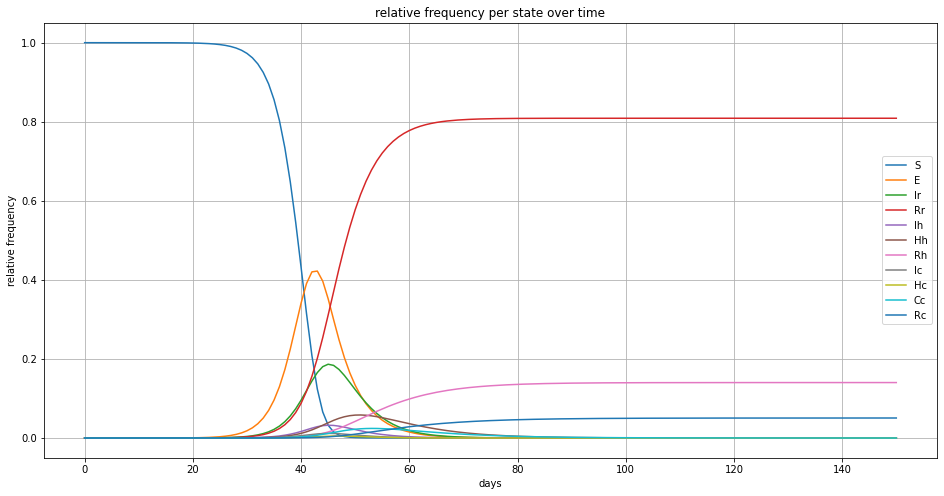

Statistics of Interest:

                                   
peak_size                  0.666092
peak_time                 44.000000
outbreak_duration        124.000000
long_run_removed           0.999858
half_removed_time         48.000000
herd_immunity_threshold    0.563358
herd_immunity_time        49.000000


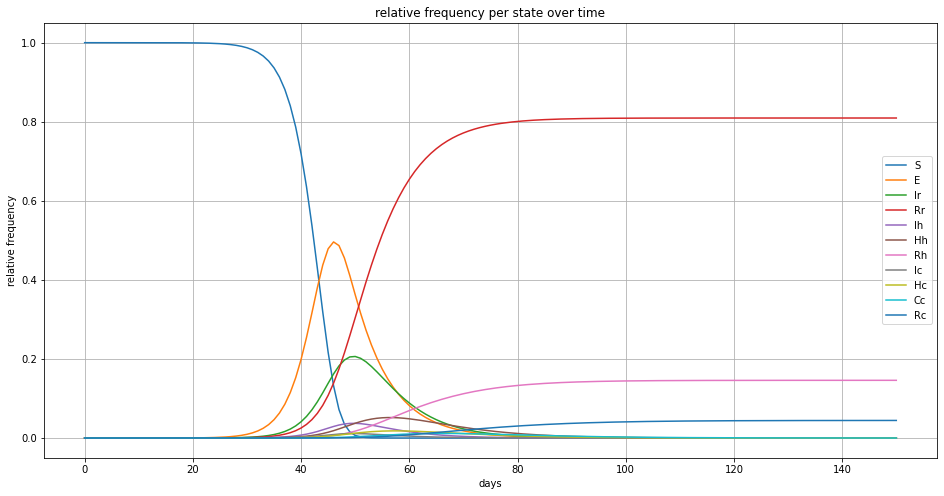

Statistics of Interest:

                                   
peak_size                  0.744366
peak_time                 47.000000
outbreak_duration        141.000000
long_run_removed           0.999931
half_removed_time         54.000000
herd_immunity_threshold    0.561500
herd_immunity_time        56.000000


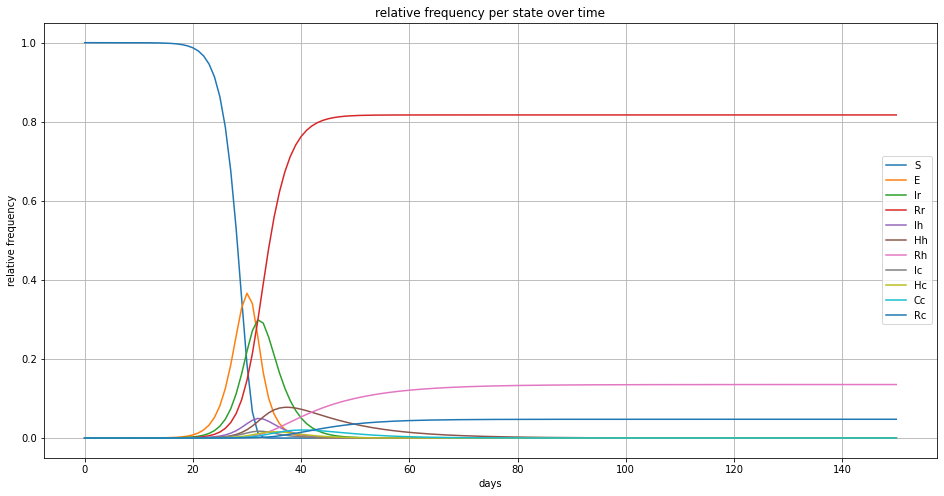

Statistics of Interest:

                                  
peak_size                 0.714177
peak_time                31.000000
outbreak_duration        97.000000
long_run_removed          0.999993
half_removed_time        35.000000
herd_immunity_threshold   0.583655
herd_immunity_time       36.000000


In [469]:
# run the stochastic model three times, view results for each run
model = KisslerModel(initVals)
for i in range(3):
    model.run(stochastic=True)
    model.summarize()

## 3. Monte Carlo

Now that we have a stochastic model and obtain different results per run, we'd like to know the expected value for these forecasted statistics of interest, as well as for the progression of the outbreak itself. We can approximate these expected values by running the simulation many times and then averaging the results. This monte carlo routine is implemented in the method `KisslerModel.monteCarlo(n)`, where `n` is the number of times to perform the experiment (where "performing the experiment" in this case means running the simulation).

Here we run the monte carlo routine with `n=10000`.

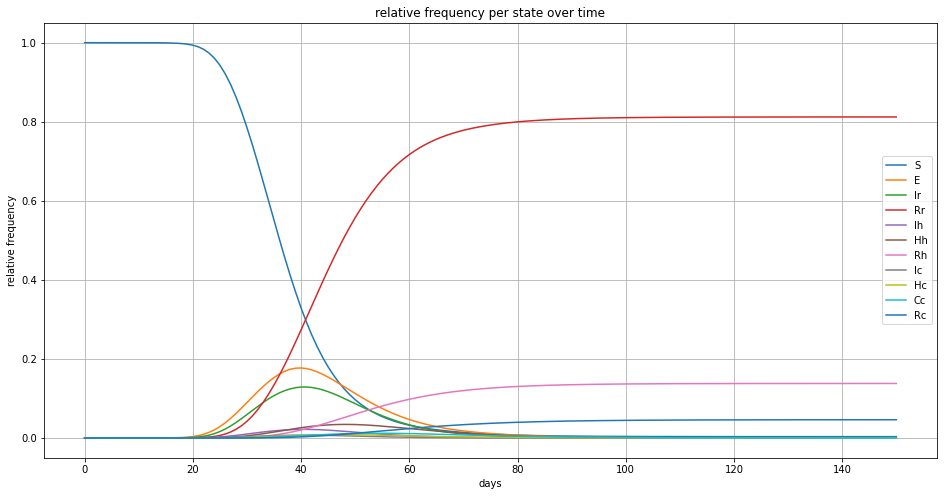

Statistics of Interest:

peak_size                    0.685443
peak_time                   41.917300
outbreak_duration          121.663700
long_run_removed             0.996461
half_removed_time           46.949900
herd_immunity_threshold      0.554028
herd_immunity_time          47.902700


In [470]:
# run the stochastic model 10000 times, compute expected value, visualize results
model = KisslerModel(initVals)
model.monteCarlo(10000)
model.summarize()